In [1]:
import logging, os

logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.get_logger().setLevel('ERROR')

import warnings

warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly
import re
from scipy.io import wavfile
from scipy.fftpack import fft
import cv2
import os
import librosa
import librosa.display
import IPython.display as ipd
from glob import glob
import skimage
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
# import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.image import resize
from tensorflow.keras.models import load_model
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint,LearningRateScheduler
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tqdm import tqdm
import tempfile
import plotly.graph_objects as go

In [3]:
from gudhi import RipsComplex
import gudhi as gd
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import pairwise_distances
from scipy.stats import wasserstein_distance
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from gudhi.representations import Landscape
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine
from gudhi.representations import PersistenceImage 
from pathos.multiprocessing import ProcessingPool as Pool
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

from pydub import AudioSegment
from pydub.utils import which
os.environ["PATH"] += os.pathsep + "/opt/homebrew/bin"
AudioSegment.converter = "/opt/homebrew/bin/ffmpeg"
AudioSegment.ffprobe = "/opt/homebrew/bin/ffprobe"

In [4]:
myPath = 'audio-emotions/1/Emotions/'
def loadFiles(aDirectory):
    myEmotionsSounds = []
    for myFile in tqdm(os.listdir(aDirectory)):
        if myFile.endswith(".wav"):
            sound = AudioSegment.from_file(os.path.join(aDirectory, myFile))
            myEmotionsSounds.append(sound)
    return myEmotionsSounds 

In [5]:
def getWaveform(aPath, aPathName):
    mySignal, mySampleRate = librosa.load(aPath)
    plt.figure(figsize=(14, 5))
    librosa.display.waveshow(mySignal, sr=mySampleRate)
    plt.title(F'The {aPathName} Sound Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()
    print(F"The {aPathName} Sound: ")
    sound = ipd.Audio(mySignal, rate=mySampleRate)
    return sound

In [6]:
def doMelSpectrogram(aSoundFiles, aFixLength = False):
    mySampleRate = 44100  
    myMelSpectrograms = []
    for i in tqdm(range(len(aSoundFiles))):
        myAudioSegment = aSoundFiles[i]
        myTempFile = tempfile.NamedTemporaryFile(delete=False, suffix=".wav")
        myTempFilePath = myTempFile.name
        myTempFile.close()
        myAudioSegment.export(myTempFilePath, format="wav")
        mySignal, mySampleRate = librosa.load(myTempFilePath, sr=mySampleRate)
        os.remove(myTempFilePath)
        mel_spectrogram = librosa.feature.melspectrogram(y=mySignal, sr=mySampleRate, n_mels=128) 
        mel_spectrogram_dbs = librosa.amplitude_to_db(mel_spectrogram, ref=np.max)
        if aFixLength:
            mel_spectrogram_dbs = librosa.util.fix_length(mel_spectrogram_dbs, size=128, axis=1)
        myMelSpectrograms.append(mel_spectrogram_dbs)
    return myMelSpectrograms

In [7]:
def computeMfccs(aDbs, aNumMfcc=13):
    myMfccList = []
    for i in tqdm(range(len(aDbs))):
        myMfcc = librosa.feature.mfcc(S=aDbs[i], n_mfcc=aNumMfcc)
        myMfccList.append(myMfcc)
    return myMfccList

In [8]:
def showMelSpectrogram(aMelSpectrogram):  
    myDfMelSpectrogram = pd.DataFrame(aMelSpectrogram)
    plt.figure(figsize=(10, 4))
    sns.heatmap(myDfMelSpectrogram, cmap='plasma', xticklabels=10, yticklabels=10)
    plt.title(f'Mel Spectrogram from an angry sound  (dB)')
    plt.xlabel('Time (s)')
    plt.ylabel('Mel Frequency Bin')
    plt.show()

In [9]:
def showMfcc(aMfcc):
    librosa.display.specshow(aMfcc, x_axis='time')
    plt.colorbar()
    plt.title('MFCC From an Angry Sound')
    plt.show()

In [10]:
def show3DPlot(aMelSpectrogram):
    fig = go.Figure(data=[
        go.Surface(z=aMelSpectrogram.T, colorscale='viridis')
    ])
    fig.update_layout(
        title='Mel Spectrogram from and angry sound 3-D plot (dB)',
        scene=dict(
            xaxis=dict(title='Time (s)'),
            yaxis=dict(title='Mel Frequency Bin'),
            zaxis=dict(title='Amplitude (dB)')
        )
    )
    fig.show()

## Preprocessing: Getting MFCCs and Spectrograms

In [11]:
myAngrySounds = loadFiles(myPath + '/Angry/')
print("Angry sounds loaded successfully")
myDisgustedSounds = loadFiles(myPath + '/Disgusted/')
print("Disgusted sounds loaded successfully")
myFearfulSounds = loadFiles(myPath + '/Fearful/')
print("Fearful sounds loaded successfully")
myHappySounds = loadFiles(myPath + '/Happy/')
print("Happy sounds loaded successfully")
myNeutralSounds = loadFiles(myPath + '/Neutral/')
print("Neutral sounds loaded successfully")
mySadSounds = loadFiles(myPath + '/Sad/')
print("Sad sounds loaded successfully")
mySurprisedSounds = loadFiles(myPath + 'Suprised/')
print("Suprised sounds loaded successfully")

100%|██████████| 2167/2167 [00:00<00:00, 3392.70it/s]


Angry sounds loaded successfully


100%|██████████| 1863/1863 [00:00<00:00, 4775.89it/s]


Disgusted sounds loaded successfully


100%|██████████| 2047/2047 [00:00<00:00, 3568.67it/s]


Fearful sounds loaded successfully


100%|██████████| 2167/2167 [00:00<00:00, 4542.59it/s]


Happy sounds loaded successfully


100%|██████████| 1795/1795 [00:00<00:00, 4752.23it/s]


Neutral sounds loaded successfully


100%|██████████| 2167/2167 [00:00<00:00, 4306.47it/s]


Sad sounds loaded successfully


100%|██████████| 592/592 [00:00<00:00, 4068.95it/s]

Suprised sounds loaded successfully


In [12]:
myMelSpectrogramsAngry = doMelSpectrogram(myAngrySounds)
myMelSpectrogramsDisgusted = doMelSpectrogram(myDisgustedSounds)
myMelSpectrogramsFearful = doMelSpectrogram(myFearfulSounds)
myMelSpectrogramsHappy = doMelSpectrogram(myHappySounds)
myMelSpectrogramsNeutral = doMelSpectrogram(myNeutralSounds)
myMelSpectrogramsSurprised = doMelSpectrogram(mySurprisedSounds)
myMelSpectrogramsSad = doMelSpectrogram(mySadSounds)


100%|██████████| 2167/2167 [00:13<00:00, 155.36it/s]


In [13]:
myMfccAngry = computeMfccs(myMelSpectrogramsAngry)
myMfccDisgusted = computeMfccs(myMelSpectrogramsDisgusted)
myMfccFearful = computeMfccs(myMelSpectrogramsFearful)
myMfccHappy = computeMfccs(myMelSpectrogramsHappy)
myMfccNeutral = computeMfccs(myMelSpectrogramsNeutral)
myMfccSurprised = computeMfccs(myMelSpectrogramsSurprised)
myMfccSad = computeMfccs(myMelSpectrogramsSad)

100%|██████████| 2167/2167 [00:00<00:00, 11291.86it/s]


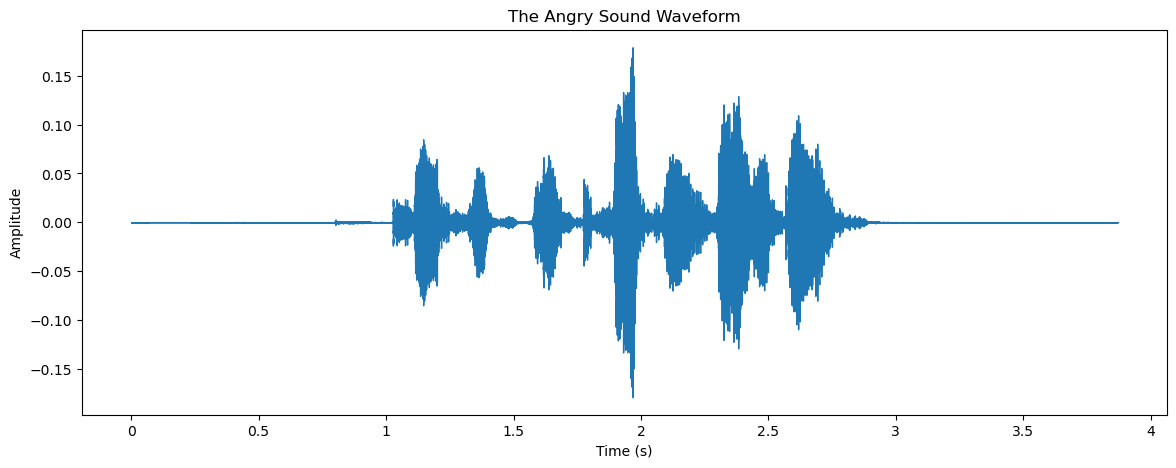

The Angry Sound: 


In [14]:
getWaveform(myPath+'/Angry/03-01-05-01-01-01-01.wav','Angry')


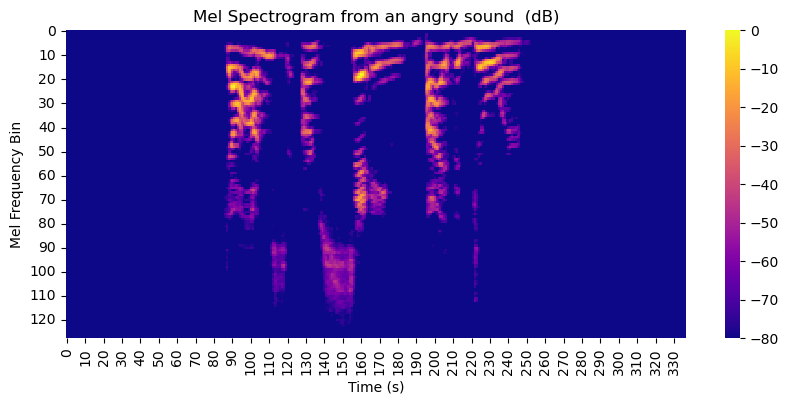

In [15]:
showMelSpectrogram(myMelSpectrogramsAngry[0])


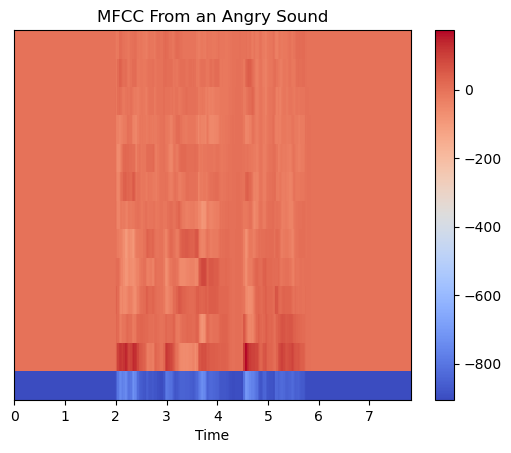

In [16]:
showMfcc(myMfccAngry[0])


In [17]:
show3DPlot(myMelSpectrogramsAngry[0])

## Computing Homologies!

In [18]:
def euclideanMetric(x, y):
    return np.linalg.norm(x - y) 
def timeBasedEuclideanMetric(x, y):
    return np.linalg.norm(x[0] - y[0]) / (2) + np.linalg.norm(x[1:] - y[1:]) / (2)


In [20]:
def computerPersistenceDiagrams(aMatrix, aMaxLength, aMaxDim, aMetric, aPlot, aNormalize):
    # Preprocess matrix
    if aNormalize:
        myTimeRow = np.arange(aMatrix.shape[1]) 
        myNormalizedMatrix = (aMatrix - np.min(aMatrix)) / (np.max(aMatrix) - np.min(aMatrix))
        myTimeRow = myTimeRow / aMatrix.shape[1]
        myNewArr = np.vstack([myTimeRow, myNormalizedMatrix])
    else:
        myNewArr = aMatrix
    
    # Compute distance matrix
    myDistanceMatrix = squareform(pdist(myNewArr.T, metric=aMetric))
    myMaxLength = min(np.abs(myDistanceMatrix).max().max() / 3, aMaxLength)

    # Compute persistences
    myRipsComplex = RipsComplex(points=myNewArr.T, max_edge_length=myMaxLength, distance_matrix=myDistanceMatrix)
    mySimplexTree = myRipsComplex.create_simplex_tree(max_dimension=aMaxDim)
    mySimplexTree.compute_persistence()
    myPersistence = mySimplexTree.persistence()

    # Compute bd matrix
    myBd = []
    for i in range(aMaxDim):
        myBdMatrix = np.array([
            [birth, death] for dim, (birth, death) in myPersistence if dim == i and death != float('inf')
        ])
        myBd.append(myBdMatrix)

    # Plot if needed
    if aPlot:
        gd.plot_persistence_diagram(mySimplexTree.persistence())

    return myBd

In [21]:
def computePersistanceFromDb(aDb, aMaxLength, aMaxDim, aMetric, aPlot, aMaxDiagrams, aNormalize):
    myMat = []
    for i, myCurr in enumerate(aDb):
        if i == aMaxDiagrams:
            break
        print(f"Computing persitance diagram for {i}")
        myPersistence = computerPersistenceDiagrams(aMatrix=myCurr, aMaxLength=aMaxLength, aMaxDim=aMaxDim, aMetric=aMetric, aPlot=aPlot, aNormalize=aNormalize)
        myMat.append(myPersistence)
    return myMat

In [69]:
def getPersitanceHeatMap(aArr, aMax, aMaxDim, aPlot = False, aShape = 32):
    myHeatmapArr = []
    for myBdMatrix in aArr:
        print(myBdMatrix)
        myPersistenceImage = PersistenceImage(
            bandwidth= aMax / 50,
            weight=lambda x: np.sqrt((x[1] - x[0])**2), 
            resolution=[aShape, aShape],    
            im_range=[0, aMax, 0, aMax]   
        )

        for i in range(aMaxDim):
            # If any persistence bd matrix found then compute heatmap
            if i < len(myBdMatrix) and len(myBdMatrix[i]) > 0:
                myHeatMap = myPersistenceImage.fit_transform([myBdMatrix[i]])[0]
                myHeatMap2d = myHeatMap.reshape(aShape, aShape)
                myHeatmapArr.append(myHeatMap2d)
                if aPlot:
                    print(myHeatMap2d.shape)
                    plt.figure()
                    plt.imshow(myHeatMap2d, cmap='hot', origin='lower')
                    plt.colorbar(label='Scaled Density')
                    plt.title('Persistence Image')
                    plt.xlabel('Birth')
                    plt.ylabel('Persistence')
                    plt.show()
            else:
                myHeatmapArr.append(np.zeros((aShape, aShape)))
    return myHeatmapArr

[array([[0.        , 0.7346329 ],
       [0.        , 0.73395842],
       [0.        , 0.64772044],
       [0.        , 0.63903224],
       [0.        , 0.62904005],
       [0.        , 0.62790845],
       [0.        , 0.62007461],
       [0.        , 0.57348075],
       [0.        , 0.56766968],
       [0.        , 0.54507826],
       [0.        , 0.54174215],
       [0.        , 0.53162272],
       [0.        , 0.53067833],
       [0.        , 0.52933868],
       [0.        , 0.51920728],
       [0.        , 0.51920491],
       [0.        , 0.51574344],
       [0.        , 0.50647345],
       [0.        , 0.50145704],
       [0.        , 0.49879855],
       [0.        , 0.49512474],
       [0.        , 0.49301638],
       [0.        , 0.4847985 ],
       [0.        , 0.47947328],
       [0.        , 0.47941936],
       [0.        , 0.47220804],
       [0.        , 0.47136509],
       [0.        , 0.47091383],
       [0.        , 0.47002702],
       [0.        , 0.46821069],
       [0

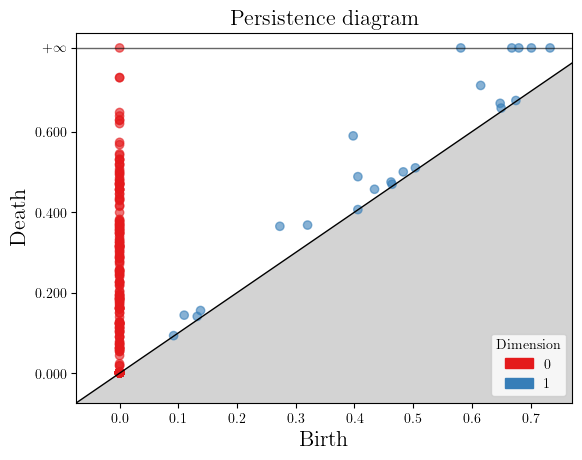

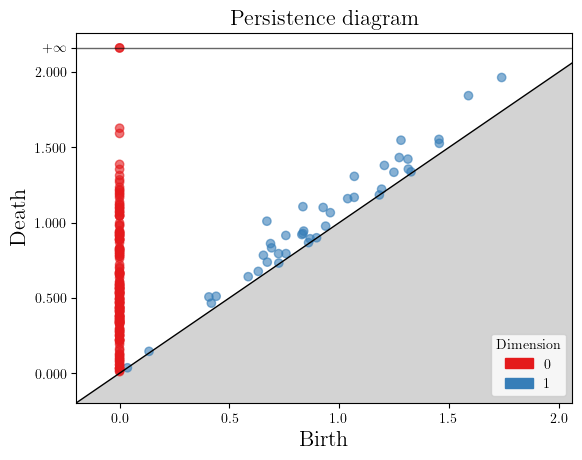

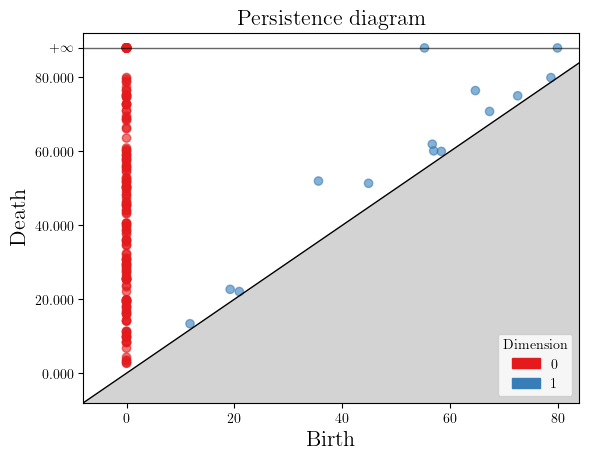

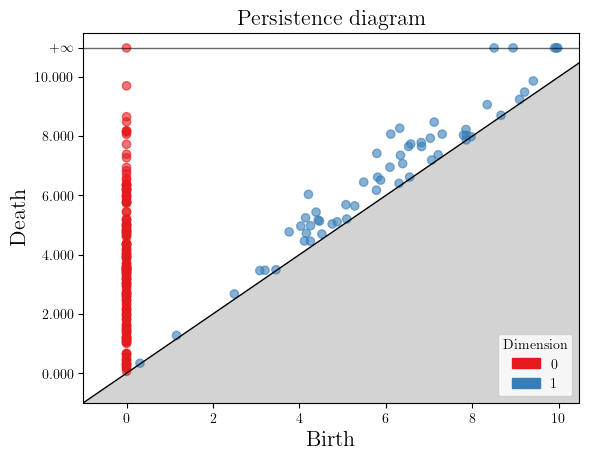

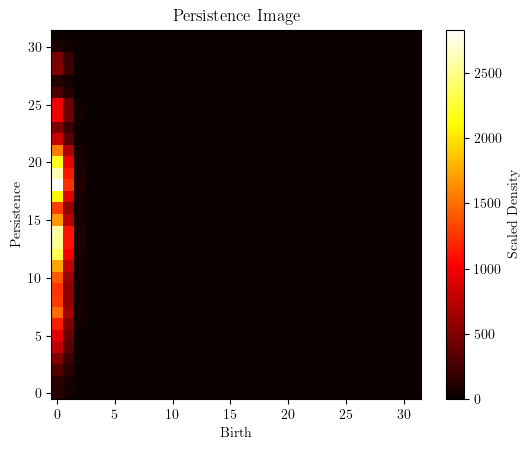

(32, 32)


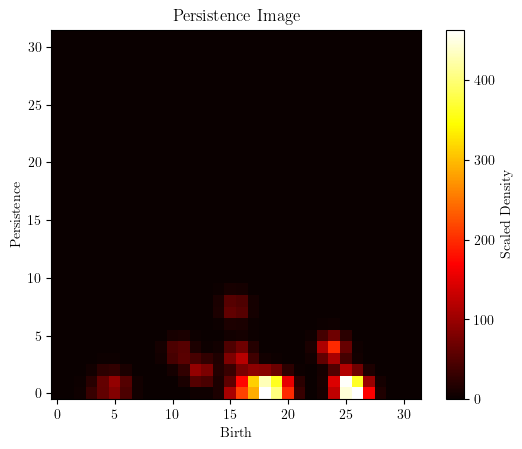

[array([[0.        , 1.62654838],
       [0.        , 1.59151511],
       [0.        , 1.38642019],
       [0.        , 1.35310265],
       [0.        , 1.3123209 ],
       [0.        , 1.28346461],
       [0.        , 1.26873007],
       [0.        , 1.23429239],
       [0.        , 1.21863151],
       [0.        , 1.21328707],
       [0.        , 1.20005278],
       [0.        , 1.18996018],
       [0.        , 1.17866515],
       [0.        , 1.16547035],
       [0.        , 1.13585208],
       [0.        , 1.12083992],
       [0.        , 1.11702806],
       [0.        , 1.10363203],
       [0.        , 1.09769867],
       [0.        , 1.09068847],
       [0.        , 1.07534264],
       [0.        , 1.07088441],
       [0.        , 1.06147914],
       [0.        , 1.04674272],
       [0.        , 1.04414658],
       [0.        , 1.04359379],
       [0.        , 0.99695784],
       [0.        , 0.98381694],
       [0.        , 0.97883175],
       [0.        , 0.94362445],
       [0

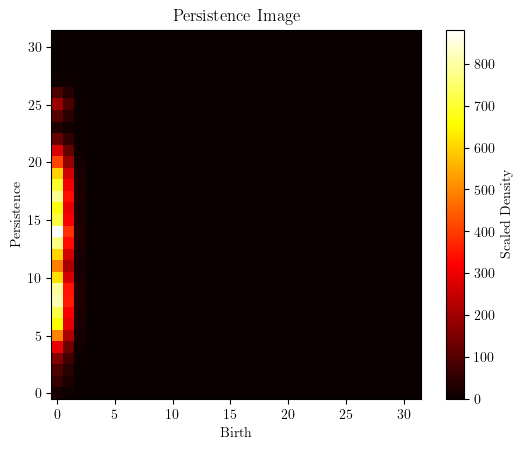

(32, 32)


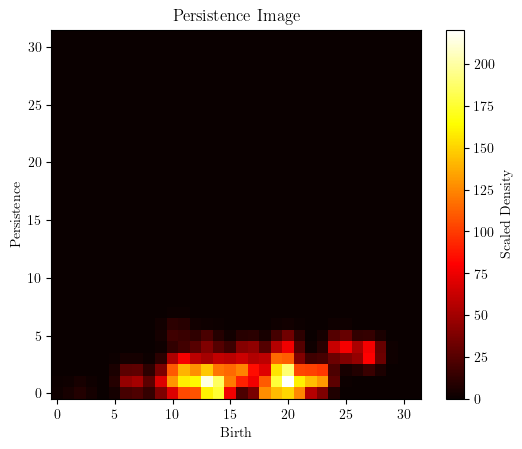

[array([[ 0.        , 79.9957428 ],
       [ 0.        , 79.57038116],
       [ 0.        , 78.98257446],
       [ 0.        , 78.64523315],
       [ 0.        , 77.33036804],
       [ 0.        , 76.47834015],
       [ 0.        , 76.4697113 ],
       [ 0.        , 75.31590271],
       [ 0.        , 75.18102264],
       [ 0.        , 75.10881805],
       [ 0.        , 74.9669342 ],
       [ 0.        , 74.67632294],
       [ 0.        , 74.54478455],
       [ 0.        , 72.8130188 ],
       [ 0.        , 72.77378845],
       [ 0.        , 72.74862671],
       [ 0.        , 72.61750031],
       [ 0.        , 71.02119446],
       [ 0.        , 71.00389099],
       [ 0.        , 69.53622437],
       [ 0.        , 68.9496994 ],
       [ 0.        , 68.69980621],
       [ 0.        , 68.37249756],
       [ 0.        , 66.41363525],
       [ 0.        , 66.10792542],
       [ 0.        , 63.61241531],
       [ 0.        , 60.92724991],
       [ 0.        , 60.46926117],
       [ 0.        

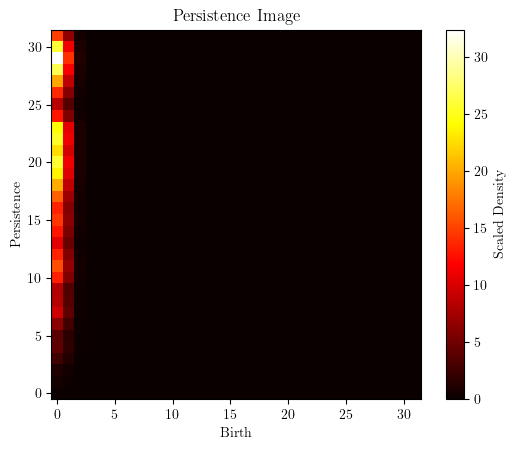

(32, 32)


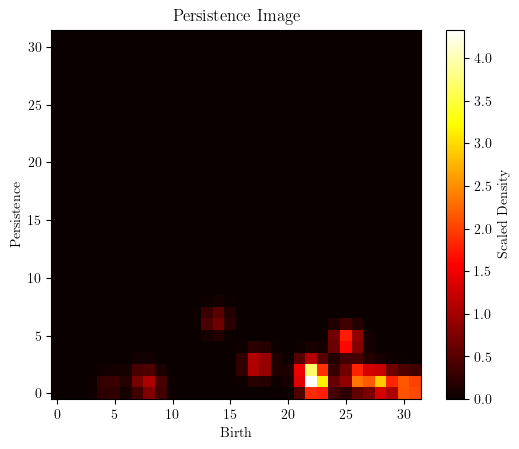

[array([[0.        , 9.69563635],
       [0.        , 8.65150197],
       [0.        , 8.4800108 ],
       [0.        , 8.17265582],
       [0.        , 8.17200103],
       [0.        , 8.12894705],
       [0.        , 8.05791239],
       [0.        , 7.72262114],
       [0.        , 7.38713613],
       [0.        , 7.26845925],
       [0.        , 6.94154141],
       [0.        , 6.82538377],
       [0.        , 6.71844712],
       [0.        , 6.57655212],
       [0.        , 6.52483463],
       [0.        , 6.39525589],
       [0.        , 6.35888408],
       [0.        , 6.34332187],
       [0.        , 6.33090503],
       [0.        , 6.33084279],
       [0.        , 6.21184017],
       [0.        , 6.21141342],
       [0.        , 6.19376375],
       [0.        , 6.18797355],
       [0.        , 6.1332716 ],
       [0.        , 6.03559553],
       [0.        , 5.97754178],
       [0.        , 5.96388285],
       [0.        , 5.93403269],
       [0.        , 5.85091963],
       [0

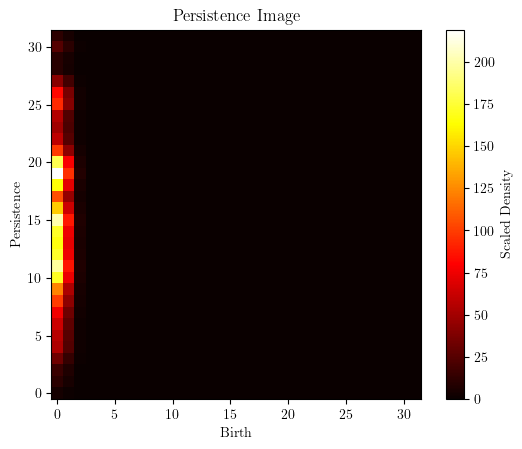

(32, 32)


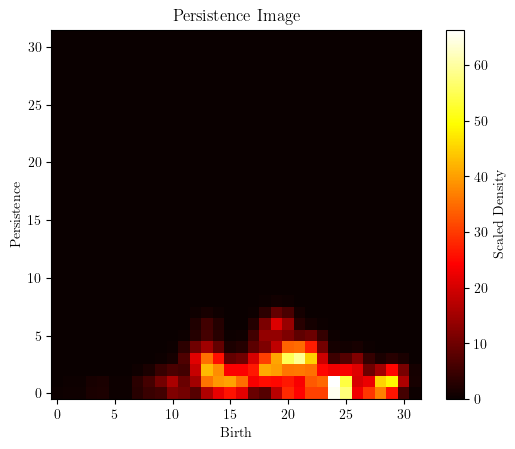

In [70]:
myPersistenceT = computerPersistenceDiagrams(aMatrix=myMelSpectrogramsAngry[0], aMaxLength=0.8, aMaxDim=2, aMetric=timeBasedEuclideanMetric, aPlot=True, aNormalize=True)
myPersistenceW = computerPersistenceDiagrams(aMatrix=myMelSpectrogramsAngry[0], aMaxLength=2, aMaxDim=2, aMetric=wasserstein_distance, aPlot=True, aNormalize=False)
myPersistenceE = computerPersistenceDiagrams(aMatrix=myMelSpectrogramsAngry[0], aMaxLength=80, aMaxDim=2, aMetric=euclideanMetric, aPlot=True, aNormalize=False)
myPersistenceWM = computerPersistenceDiagrams(aMatrix=myMfccAngry[0], aMaxLength=10, aMaxDim=2, aMetric=wasserstein_distance, aPlot=True, aNormalize=False)

heatmaps = getPersitanceHeatMap(aArr=[myPersistenceT], aMax=0.8, aMaxDim=2, aPlot=True)
heatmaps = getPersitanceHeatMap(aArr=[myPersistenceW], aMax=2, aMaxDim=2, aPlot=True)
heatmaps = getPersitanceHeatMap(aArr=[myPersistenceE], aMax=80, aMaxDim=2, aPlot=True)
heatmaps = getPersitanceHeatMap(aArr=[myPersistenceWM], aMax=10, aMaxDim=2, aPlot=True)

[array([[0.        , 0.44294377],
       [0.        , 0.39996268],
       [0.        , 0.34101474],
       [0.        , 0.33924513],
       [0.        , 0.33889686],
       [0.        , 0.33629635],
       [0.        , 0.33468434],
       [0.        , 0.33382303],
       [0.        , 0.32756831],
       [0.        , 0.31776339],
       [0.        , 0.31728122],
       [0.        , 0.31653759],
       [0.        , 0.31148981],
       [0.        , 0.31141199],
       [0.        , 0.31021075],
       [0.        , 0.30934614],
       [0.        , 0.30849117],
       [0.        , 0.30502377],
       [0.        , 0.30440138],
       [0.        , 0.30168408],
       [0.        , 0.30060036],
       [0.        , 0.29901716],
       [0.        , 0.29854327],
       [0.        , 0.29719963],
       [0.        , 0.2949146 ],
       [0.        , 0.29192534],
       [0.        , 0.29037215],
       [0.        , 0.29027531],
       [0.        , 0.28572693],
       [0.        , 0.2828298 ],
       [0

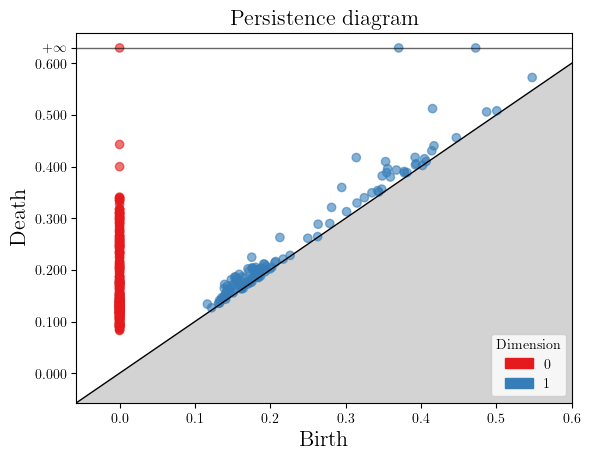

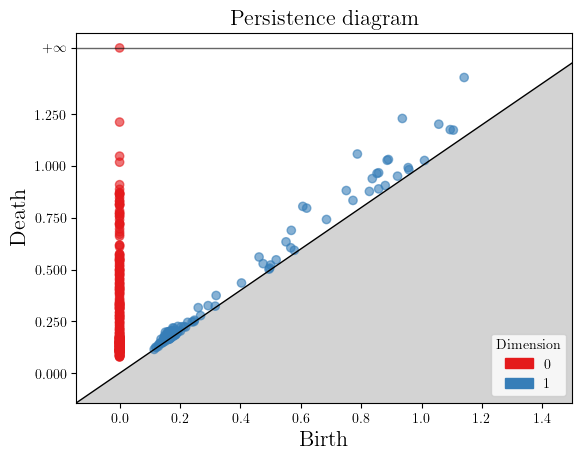

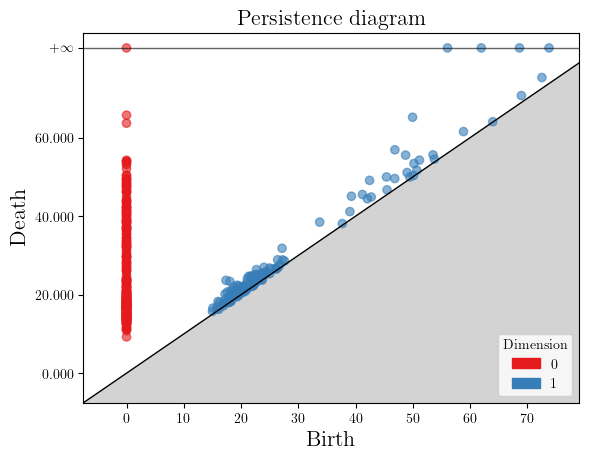

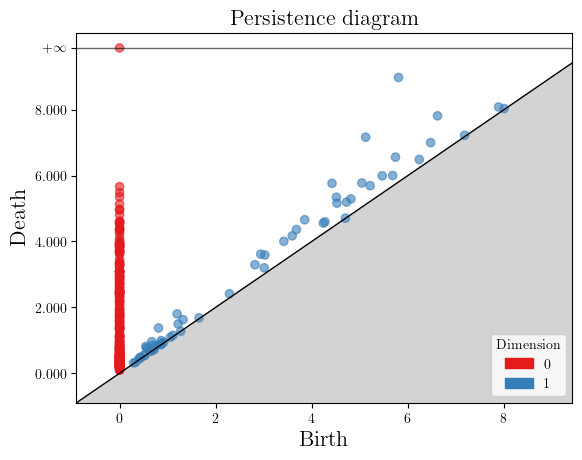

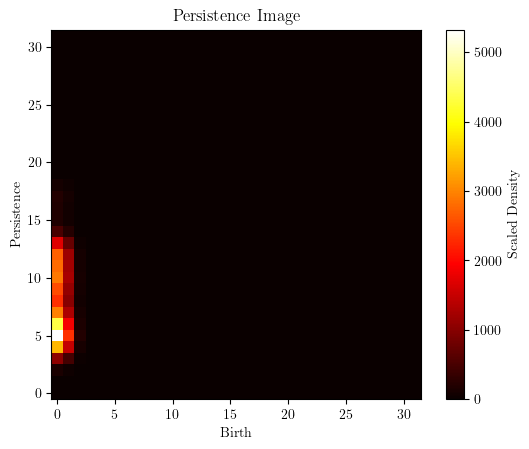

(32, 32)


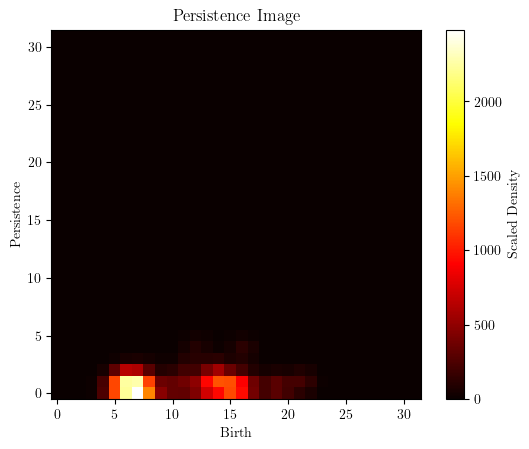

[array([[0.        , 1.21271905],
       [0.        , 1.04825388],
       [0.        , 1.01900628],
       [0.        , 0.91035794],
       [0.        , 0.88819696],
       [0.        , 0.8727099 ],
       [0.        , 0.86700734],
       [0.        , 0.86641626],
       [0.        , 0.86481448],
       [0.        , 0.86115547],
       [0.        , 0.84686165],
       [0.        , 0.83130783],
       [0.        , 0.83015628],
       [0.        , 0.81786682],
       [0.        , 0.81606914],
       [0.        , 0.81115431],
       [0.        , 0.81068423],
       [0.        , 0.78432624],
       [0.        , 0.77505247],
       [0.        , 0.77002978],
       [0.        , 0.76990971],
       [0.        , 0.75822911],
       [0.        , 0.75748964],
       [0.        , 0.74117644],
       [0.        , 0.7234889 ],
       [0.        , 0.72173244],
       [0.        , 0.71974003],
       [0.        , 0.71341318],
       [0.        , 0.69667497],
       [0.        , 0.6821751 ],
       [0

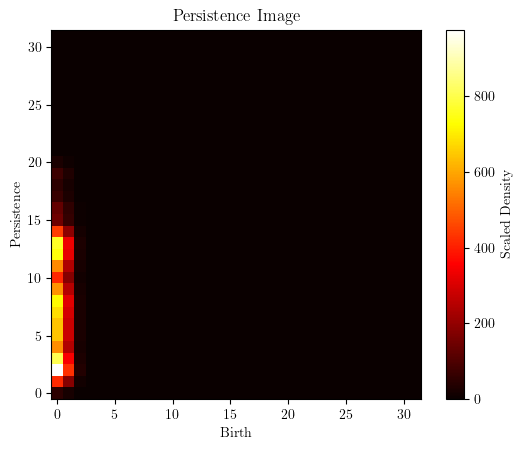

(32, 32)


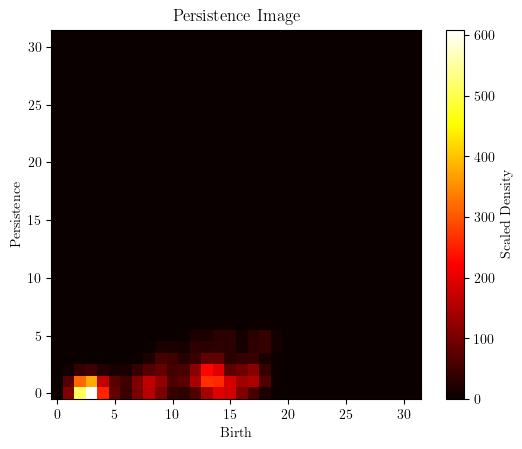

[array([[ 0.        , 65.71863556],
       [ 0.        , 63.67144775],
       [ 0.        , 54.23978043],
       [ 0.        , 53.95664215],
       [ 0.        , 53.90091705],
       [ 0.        , 53.48483658],
       [ 0.        , 53.0891037 ],
       [ 0.        , 52.0883522 ],
       [ 0.        , 50.44241714],
       [ 0.        , 50.32343292],
       [ 0.        , 49.51578522],
       [ 0.        , 49.50333786],
       [ 0.        , 49.17280197],
       [ 0.        , 49.03600693],
       [ 0.        , 48.48122406],
       [ 0.        , 48.38164139],
       [ 0.        , 47.94687271],
       [ 0.        , 47.77347946],
       [ 0.        , 47.5201683 ],
       [ 0.        , 47.44434357],
       [ 0.        , 46.86375809],
       [ 0.        , 46.38547134],
       [ 0.        , 46.13696289],
       [ 0.        , 46.12146759],
       [ 0.        , 44.93018723],
       [ 0.        , 44.13470459],
       [ 0.        , 44.02911758],
       [ 0.        , 43.68097305],
       [ 0.        

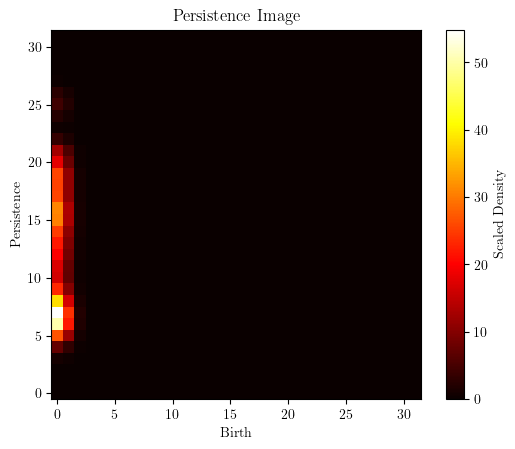

(32, 32)


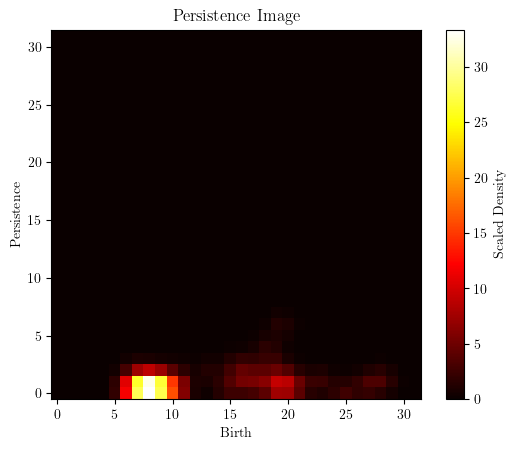

[array([[0.        , 5.66528647],
       [0.        , 5.48751255],
       [0.        , 5.35880378],
       [0.        , 5.13844386],
       [0.        , 4.96801518],
       [0.        , 4.9631862 ],
       [0.        , 4.81206653],
       [0.        , 4.6183165 ],
       [0.        , 4.58963468],
       [0.        , 4.56553214],
       [0.        , 4.5391362 ],
       [0.        , 4.42151943],
       [0.        , 4.37904375],
       [0.        , 4.3624524 ],
       [0.        , 4.31859823],
       [0.        , 4.2441936 ],
       [0.        , 4.1010451 ],
       [0.        , 4.01031294],
       [0.        , 3.96502644],
       [0.        , 3.94306505],
       [0.        , 3.93583643],
       [0.        , 3.89707061],
       [0.        , 3.887161  ],
       [0.        , 3.86951882],
       [0.        , 3.85923428],
       [0.        , 3.8393053 ],
       [0.        , 3.79458171],
       [0.        , 3.71538408],
       [0.        , 3.71341712],
       [0.        , 3.69933785],
       [0

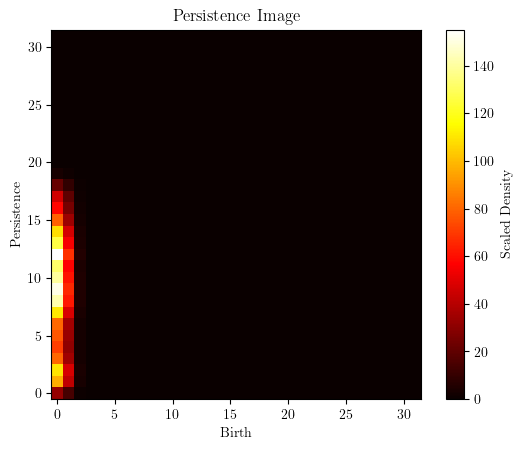

(32, 32)


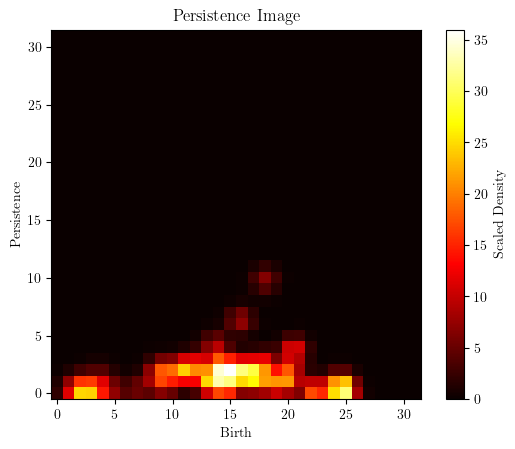

In [71]:
myPersistenceT = computerPersistenceDiagrams(aMatrix=myMelSpectrogramsDisgusted[0], aMaxLength=0.8, aMaxDim=2, aMetric=timeBasedEuclideanMetric, aPlot=True, aNormalize=True)
myPersistenceW = computerPersistenceDiagrams(aMatrix=myMelSpectrogramsDisgusted[0], aMaxLength=2, aMaxDim=2, aMetric=wasserstein_distance, aPlot=True, aNormalize=False)
myPersistenceE = computerPersistenceDiagrams(aMatrix=myMelSpectrogramsDisgusted[0], aMaxLength=80, aMaxDim=2, aMetric=euclideanMetric, aPlot=True, aNormalize=False)
myPersistenceWM = computerPersistenceDiagrams(aMatrix=myMfccDisgusted[0], aMaxLength=10, aMaxDim=2, aMetric=wasserstein_distance, aPlot=True, aNormalize=False)

heatmaps = getPersitanceHeatMap(aArr=[myPersistenceT], aMax=0.8, aMaxDim=2, aPlot=True)
heatmaps = getPersitanceHeatMap(aArr=[myPersistenceW], aMax=2, aMaxDim=2, aPlot=True)
heatmaps = getPersitanceHeatMap(aArr=[myPersistenceE], aMax=80, aMaxDim=2, aPlot=True)
heatmaps = getPersitanceHeatMap(aArr=[myPersistenceWM], aMax=10, aMaxDim=2, aPlot=True)

In [72]:
def parallelComputePersitence(args):
    return computePersistanceFromDb(*args)

In [73]:
def saveResults(aPattern, aResults, aMaxDim):
    for i in range(len(aResults)):
        for k in range(len(aResults[i])):
            for j in range(aMaxDim):
                np.save(f'./savefiles/{aPattern}_{i}_{k}_{j}.npy', aResults[i][k][j])

In [74]:
def computeHeatMaps(aResults, aMaxDim, aMaxDist, aName):
    myNewHeat = []
    for i in range(len(aResults)):
        print(f'Computing {i}')
        myHeat = getPersitanceHeatMap(aResults[i], aMax=aMaxDist, aMaxDim=aMaxDim)
        myNewHeat.append(myHeat)
        for j in range(len(myNewHeat[i])):
            print(j)
            np.save(f'./savefiles/{aName}Heat_{i}_{j}.npy', myNewHeat[i][j])

In [ ]:
maxdim = 2
metrics = [timeBasedEuclideanMetric, wasserstein_distance, euclideanMetric]
scaled = [True, False, False]
maxdists = [0.8, 2, 80]
names = ['timeMetric', 'wasserstein', 'euclidean']
for metric, scale, maxdist, name in zip(metrics, scaled, maxdists, names):
    args = [
        (myMelSpectrogramsAngry, maxdist, maxdim, metric, False, len(myMelSpectrogramsAngry), scale),
        (myMelSpectrogramsDisgusted, maxdist, maxdim, metric, False, len(myMelSpectrogramsDisgusted), scale),
        (myMelSpectrogramsFearful, maxdist, maxdim, metric, False, len(myMelSpectrogramsFearful), scale),
        (myMelSpectrogramsHappy, maxdist, maxdim, metric, False, len(myMelSpectrogramsHappy), scale),
        (myMelSpectrogramsNeutral, maxdist, maxdim, metric, False, len(myMelSpectrogramsNeutral), scale),
        (myMelSpectrogramsSurprised, maxdist, maxdim, metric, False, len(myMelSpectrogramsSurprised), scale),
        (myMelSpectrogramsSad, maxdist, maxdim, metric, False, len(myMelSpectrogramsSad), scale)
    ]
    with Pool() as pool:
        results = pool.map(parallelComputePersitence, args)
    saveResults(aPattern=name, aResults=results, aMaxDim=maxdim)
    computeHeatMaps(aResults=results, aMaxDim=maxdim, aMaxDist=maxdist, aName=name)
    print('To the next!')

Computing persitance diagram for 0
Computing persitance diagram for 1
Computing persitance diagram for 0
Computing persitance diagram for 2
Computing persitance diagram for 1
Computing persitance diagram for 3
Computing persitance diagram for 2
Computing persitance diagram for 0
Computing persitance diagram for 3
Computing persitance diagram for 4
Computing persitance diagram for 5
Computing persitance diagram for 6
Computing persitance diagram for 0
Computing persitance diagram for 4
Computing persitance diagram for 1
Computing persitance diagram for 1
Computing persitance diagram for 5
Computing persitance diagram for 7
Computing persitance diagram for 6
Computing persitance diagram for 7
Computing persitance diagram for 0
Computing persitance diagram for 8
Computing persitance diagram for 0
Computing persitance diagram for 2
Computing persitance diagram for 1
Computing persitance diagram for 8
Computing persitance diagram for 9
Computing persitance diagram for 2
Computing persitance

In [ ]:
maxDim = 2
maxdist = 10
args = [
    (myMfccAngry, maxdist, maxDim, wasserstein_distance, False, len(myMfccAngry), False),
    (myMfccDisgusted, maxdist, maxDim, wasserstein_distance, False, len(myMfccDisgusted), False),
    (myMfccFearful, maxdist, maxDim, wasserstein_distance, False, len(myMfccFearful), False),
    (myMfccHappy, maxdist, maxDim, wasserstein_distance, False, len(myMfccHappy), False),
    (myMfccNeutral, maxdist, maxDim, wasserstein_distance, False, len(myMfccNeutral), False),
    (myMfccSurprised, maxdist, maxDim, wasserstein_distance, False, len(myMfccSurprised), False),
    (myMfccSad, maxdist, maxDim, wasserstein_distance, False, len(myMfccSad), False)
]
with Pool() as pool:
    results = pool.map(parallelComputePersitence, args)
saveResults(aPattern='wassersteinMfcc', aResults=results, aMaxDim=maxDim)
computeHeatMaps(aResults=results, aMaxDim=maxDim, aMaxDist=maxdist, aName='wassersteinMfcc')


In [ ]:
myMelSpectrogramsAngry = doMelSpectrogram(myAngrySounds, True)
myMelSpectrogramsDisgusted = doMelSpectrogram(myDisgustedSounds, True)
myMelSpectrogramsFearful = doMelSpectrogram(myFearfulSounds, True)
myMelSpectrogramsHappy = doMelSpectrogram(myHappySounds, True)
myMelSpectrogramsNeutral = doMelSpectrogram(myNeutralSounds, True)
myMelSpectrogramsSurprised = doMelSpectrogram(mySurprisedSounds, True)
myMelSpectrogramsSad = doMelSpectrogram(mySadSounds, True)

In [29]:
for i in range(len(myMelSpectrogramsAngry)):
    np.save(f'./savefiles/mel_spectrogram_dbs_angry_{i}.npy', myMelSpectrogramsAngry[i])
for i in range(len(myMelSpectrogramsDisgusted)):
    np.save(f'./savefiles/mel_spectrogram_dbs_disgusted_{i}.npy', myMelSpectrogramsDisgusted[i])
for i in range(len(myMelSpectrogramsFearful)):
    np.save(f'./savefiles/mel_spectrogram_dbs_fearful_{i}.npy', myMelSpectrogramsFearful[i])
for i in range(len(myMelSpectrogramsHappy)):
    np.save(f'./savefiles/mel_spectrogram_dbs_happy_{i}.npy', myMelSpectrogramsHappy[i])
for i in range(len(myMelSpectrogramsSurprised)):
    np.save(f'./savefiles/mel_spectrogram_dbs_surprised_{i}.npy', myMelSpectrogramsSurprised[i])
for i in range(len(myMelSpectrogramsSad)):
    np.save(f'./savefiles/mel_spectrogram_dbs_sad_{i}.npy', myMelSpectrogramsSad[i])
for i in range(len(myMelSpectrogramsNeutral)):
    np.save(f'./savefiles/mel_spectrogram_dbs_neutral_{i}.npy', myMelSpectrogramsNeutral[i])

In [81]:
folder = './savefiles'

def findFilesFromPattern(pattern):
    pattern = re.compile(pattern + r'_(\d+)_(\d+)_(\d+)\.npy')
    heatmaps_dict = {}
    for filename in os.listdir(folder):
        match = pattern.match(filename)
        if match:
            i, j, k = map(int, match.groups())
            filepath = os.path.join(folder, filename)
            data = np.load(filepath)
            
            if i not in heatmaps_dict:
                heatmaps_dict[i] = []
            
            while len(heatmaps_dict[i]) <= j:
                heatmaps_dict[i].append([])
            
            while len(heatmaps_dict[i][j]) <= k:
                heatmaps_dict[i][j].append(None)
            
            heatmaps_dict[i][j][k] = data
    return [heatmaps_dict[i] for i in sorted(heatmaps_dict.keys())]